# Baseline Model

In [1]:
# Data manipulation & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & modeling (sklearn & imblearn)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report, 
    roc_auc_score, precision_recall_curve, auc, fbeta_score
)
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Neural networks - choose one depending on your preference:
# For PyTorch:


# For TensorFlow/Keras:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


c:\Users\user\anaconda3\envs\new-env\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\user\anaconda3\envs\new-env\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
df=pd.read_csv('u5mr_clean.csv')

In [3]:
# Make a safe working copy
df = df.copy()

# Object ID
df['CASEID'] = df['CASEID'].astype('object')

# Continuous floats
float_vars = [
    'Age in 5-year groups',
    'Birth weight in kilograms (3 decimals)',
    'Childs weight in kilograms (1 decimal)',
    'Childs height in centimeters (1 decimal)',
    'Months of breastfeeding',
    'When child put to breast',
    'Height/Age standard deviation (new WHO)',
    'Weight/Age standard deviation (new WHO)',
    'Weight/Height standard deviation (new WHO)'
]
df[float_vars] = df[float_vars].apply(pd.to_numeric, errors="coerce").astype('float64')

# Discrete ints (nullable safe type)
int_vars = [
    'Number of household members (listed)',
    'Birth order number',
    'Preceding birth interval (months)',
    'Succeeding birth interval (months)',
    'Duration of pregnancy in months',
    'Timing of 1st antenatal check (months)',
    'Number of antenatal visits during pregnancy',
    'Entries in pregnancy and postnatal care roster',
    'Minutes to nearest healthcare facility',
    'Number of tetanus injections before birth',
    'Number of tetanus injections before pregnancy'
]
df[int_vars] = df[int_vars].apply(pd.to_numeric, errors="coerce").astype('Int64')

# Categorical (nominal/ordinal)
cat_vars = [
    'Region',
    'Type of place of residence',
    'Highest educational level',
    'Religion',
    'Ethnicity',
    'Wealth index combined',
    'Type of cooking fuel (smoke exposure, indoor air pollution)',
    'Sex of child',
    'Place of delivery',
    'Size of child at birth',
    'Has health card and or other vaccination document',
    'Ever had vaccination',
    'Place where most vaccinations were received',
    'Yellow fever vaccine',
    'Currently breastfeeding',
    'Given child anything other than breast milk',
    'In contact with someone with cough or TB',
    'Source of drinking water',
    'Main floor material',
    'Visited health facility last 12 months',
    'Getting medical help for self: distance to health facility',
    'Mode of transportation to nearest healthcare facility',
]
df[cat_vars] = df[cat_vars].astype('category')

In [4]:
df.columns

Index(['CASEID', 'Age in 5-year groups', 'Region',
       'Type of place of residence', 'Highest educational level', 'Religion',
       'Ethnicity', 'Number of household members (listed)',
       'Wealth index combined',
       'Type of cooking fuel (smoke exposure, indoor air pollution)',
       ...
       'Received inactivated polio (IPV)_missing',
       'Received Rotavirus 2_missing',
       'Place where most vaccinations were received_missing',
       'Yellow fever vaccine_missing',
       'Given child anything other than breast milk_missing',
       'Visited health facility last 12 months_missing',
       'Getting medical help for self: distance to health facility_missing',
       'Mode of transportation to nearest healthcare facility_missing',
       'prenatal_help_missing', 'delivery_help_missing'],
      dtype='object', length=104)

## Feature Engineering

In [5]:
# pattern to drop all columns that end with '_missing' or contain 'vaccine'
leakage_cols = [col for col in df.columns
                if col.endswith('_missing')
                or 'vaccine' in col.lower()
                or 'Received' in col]

# explicitly drop known outcome columns
outcome_cols = [
    'under5_mortality','infant_mortality','neonatal_mortality',
    'mortality_category'
]

In [6]:
leakage_cols

['Received BCG',
 'Received POLIO 1',
 'Received POLIO 2',
 'Received POLIO 3',
 'Received POLIO 0',
 'Received MEASLES 1',
 'Received MEASLES 2',
 'Received Pentavalent 1',
 'Received Pentavalent 2',
 'Received Pentavalent 3',
 'Received Pneumococcal 1',
 'Received Pneumococcal 2',
 'Received Pneumococcal 3',
 'Received Rotavirus 1',
 'Received inactivated polio (IPV)',
 'Received Rotavirus 2',
 'Yellow fever vaccine',
 'Preceding birth interval (months)_missing',
 'Succeeding birth interval (months)_missing',
 'Timing of 1st antenatal check (months)_missing',
 'Number of antenatal visits during pregnancy_missing',
 'Birth weight in kilograms (3 decimals)_missing',
 'Ever had vaccination_missing',
 'Months of breastfeeding_missing',
 'When child put to breast_missing',
 'Minutes to nearest healthcare facility_missing',
 'Number of tetanus injections before birth_missing',
 'Number of tetanus injections before pregnancy_missing',
 'Place of delivery_missing',
 'Size of child at birth_m

In [7]:
## Handle skewed numeric features
# Log transform household size to reduce right skew
if 'Number of household members (listed)' in df.columns:
    df['log_household_size'] = np.log1p(df['Number of household members (listed)'])

In [8]:
# Socioeconomic score: combine wealth + education (if both exist and numeric/categorical)
if {'Wealth index combined','Highest educational level'}.issubset(df.columns):
    # Ensure we have numeric codes for both
    df['Wealth index combined'] = df['Wealth index combined'].astype('category').cat.codes
    df['Highest educational level'] = df['Highest educational level'].astype('category').cat.codes
    df['socioeconomic'] = (df['Wealth index combined']
                           + df['Highest educational level'])

In [9]:
# Interval features
if 'Preceding birth interval (months)' in df.columns:
    df['short_birth_interval'] = (
        df['Preceding birth interval (months)'] < 24
    ).astype(int)

In [10]:
for col in ['Ethnicity', 'Religion']:
    if col in df.columns:
        # ensure it's plain string, not Categorical
        df[col] = df[col].astype(str)

        counts = df[col].value_counts()
        rare = counts[counts < 50].index

        # replace all rare categories with "Other"
        df[col] = df[col].replace(list(rare), 'Other')


In [11]:
X = df.drop(columns=leakage_cols + outcome_cols + ['CASEID'])

In [12]:
corr = X.corr(numeric_only=True).abs()
high_corr = np.where(corr > 0.9)
pairs = [(corr.index[i], corr.columns[j])
         for i,j in zip(*high_corr)
         if i < j]
print(pairs)

[('Number of household members (listed)', 'log_household_size'), ('Wealth index combined', 'socioeconomic'), ('Childs weight in kilograms (1 decimal)', 'Childs height in centimeters (1 decimal)')]


In [13]:
# create BMI column
df['child_BMI'] = df['Childs weight in kilograms (1 decimal)'] / (
    (df['Childs height in centimeters (1 decimal)'] / 100) ** 2
)

# drop originals to avoid multicollinearity
df = df.drop(columns=[
    'Childs weight in kilograms (1 decimal)',
    'Childs height in centimeters (1 decimal)',
    'Number of household members (listed)',
    'Wealth index combined'
])
df['child_BMI'] = df['child_BMI'].round(2)

In [14]:
print("Feature engineering complete. New shape:", df.shape)

Feature engineering complete. New shape: (19530, 104)


In [15]:
df.head()

,CASEID,Age in 5-year groups,Region,Type of place of residence,Highest educational level,Religion,Ethnicity,"Type of cooking fuel (smoke exposure, indoor air pollution)",Birth order number,Sex of child,...,Given child anything other than breast milk_missing,Visited health facility last 12 months_missing,Getting medical help for self: distance to health facility_missing,Mode of transportation to nearest healthcare facility_missing,prenatal_help_missing,delivery_help_missing,log_household_size,socioeconomic,short_birth_interval,child_BMI
0,1 4 2,4.0,1.0,1.0,0,7.0,11.0,2.0,4,1.0,...,0,0,0,0,0,0,1.94591,3,0,1.92
1,1 13 2,5.0,1.0,1.0,2,1.0,3.0,2.0,5,2.0,...,1,0,0,0,1,1,2.197225,6,0,1.79
2,1 26 2,3.0,1.0,1.0,2,3.0,3.0,2.0,3,1.0,...,1,0,0,0,1,1,1.791759,5,1,1.45
3,1 42 1,4.0,1.0,1.0,2,4.0,3.0,2.0,1,2.0,...,1,1,1,1,1,1,1.386294,6,0,1.40
4,1 55 2,4.0,1.0,1.0,2,2.0,3.0,2.0,2,1.0,...,1,1,1,1,0,0,1.609438,6,1,1.69


## Baseline Logistic model

In [16]:
cat_cols = X.select_dtypes(include=['object','category']).columns
num_cols = X.select_dtypes(exclude=['object','category']).columns

In [17]:

cat_cols

Index(['Region', 'Type of place of residence', 'Religion', 'Ethnicity',
       'Type of cooking fuel (smoke exposure, indoor air pollution)',
       'Sex of child', 'Place of delivery', 'Size of child at birth',
       'Has health card and or other vaccination document',
       'Ever had vaccination', 'Place where most vaccinations were received',
       'Currently breastfeeding',
       'Given child anything other than breast milk',
       'In contact with someone with cough or TB', 'Source of drinking water',
       'Main floor material', 'Visited health facility last 12 months',
       'Getting medical help for self: distance to health facility',
       'Mode of transportation to nearest healthcare facility',
       'prenatal_help', 'delivery_help'],
      dtype='object')

In [18]:
# Preprocessing: scale numeric + one-hot encode categoricals
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

baseline_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [19]:
from sklearn.metrics import roc_curve

In [20]:
def baseline_logistic(X, y, target_name):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fit baseline model
    baseline_pipe.fit(X_train, y_train)

    # Predictions
    y_pred  = baseline_pipe.predict(X_test)
    y_proba = baseline_pipe.predict_proba(X_test)[:, 1]  # for AUC metrics

    # --- Evaluation ---
    print(f"\n--- Baseline Logistic Regression: {target_name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred, digits=3))

    # F2 score
    f2 = fbeta_score(y_test, y_pred, beta=2)
    print(f"F2 Score: {f2:.3f}")

    # ROC-AUC
    roc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {roc:.3f}")

    # Precision–Recall AUC
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC: {pr_auc:.3f}")

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0','Pred 1'],
                yticklabels=['True 0','True 1'])
    plt.title(f"Confusion Matrix: {target_name}")
    plt.show()
    
    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {target_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # --- Precision-Recall Curve ---
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {target_name}')
    plt.legend(loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.show()


--- Baseline Logistic Regression: Under-5 Mortality ---
Accuracy: 0.979
              precision    recall  f1-score   support

           0      0.987     0.991     0.989      3767
           1      0.734     0.655     0.692       139

    accuracy                          0.979      3906
   macro avg      0.861     0.823     0.841      3906
weighted avg      0.978     0.979     0.979      3906

F2 Score: 0.669
ROC-AUC: 0.988
PR-AUC: 0.737


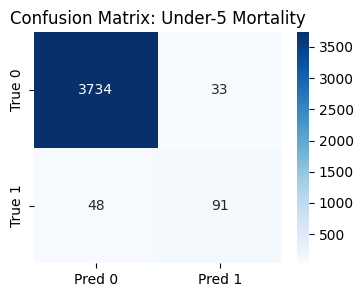

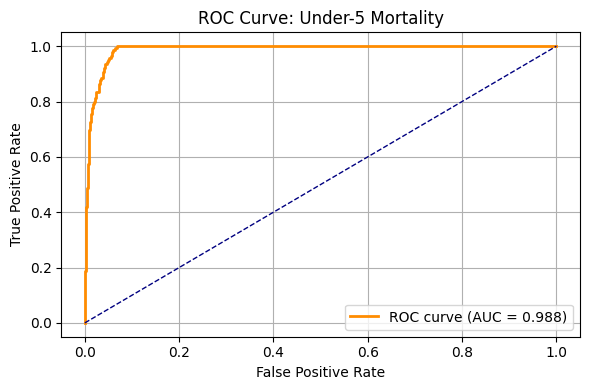

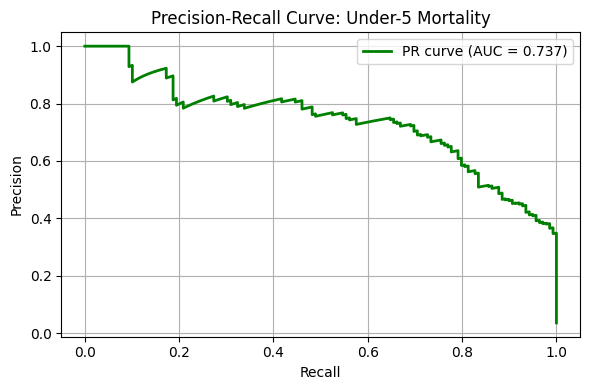


--- Baseline Logistic Regression: Infant Mortality ---
Accuracy: 0.990
              precision    recall  f1-score   support

           0      0.991     0.999     0.995      3870
           1      0.167     0.028     0.048        36

    accuracy                          0.990      3906
   macro avg      0.579     0.513     0.521      3906
weighted avg      0.983     0.990     0.986      3906

F2 Score: 0.033
ROC-AUC: 0.971
PR-AUC: 0.187


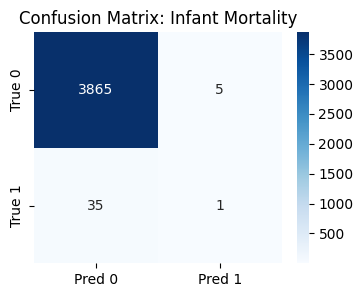

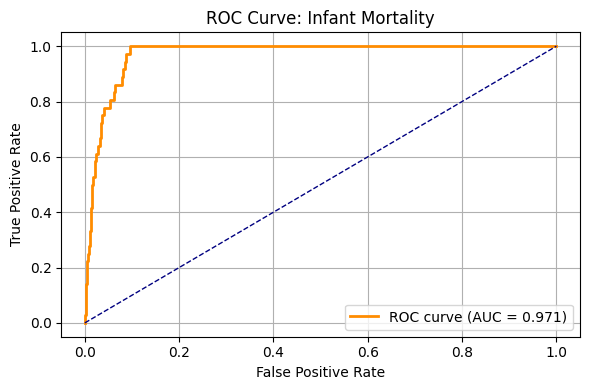

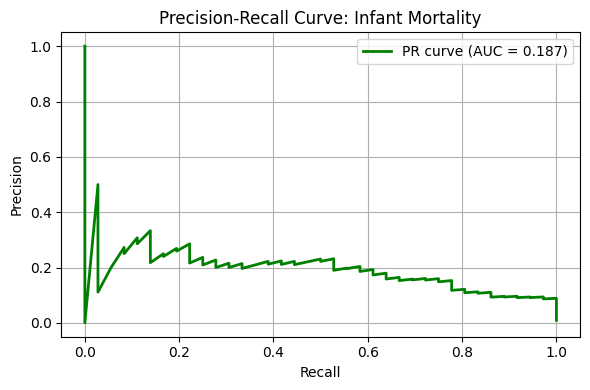


--- Baseline Logistic Regression: Neonatal Mortality ---
Accuracy: 0.984
              precision    recall  f1-score   support

           0      0.988     0.996     0.992      3819
           1      0.741     0.460     0.567        87

    accuracy                          0.984      3906
   macro avg      0.864     0.728     0.780      3906
weighted avg      0.982     0.984     0.983      3906

F2 Score: 0.498
ROC-AUC: 0.985
PR-AUC: 0.655


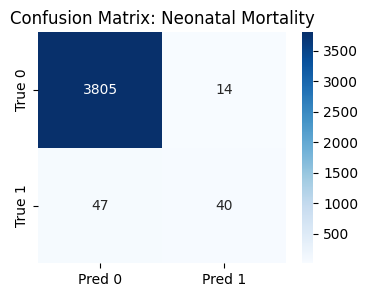

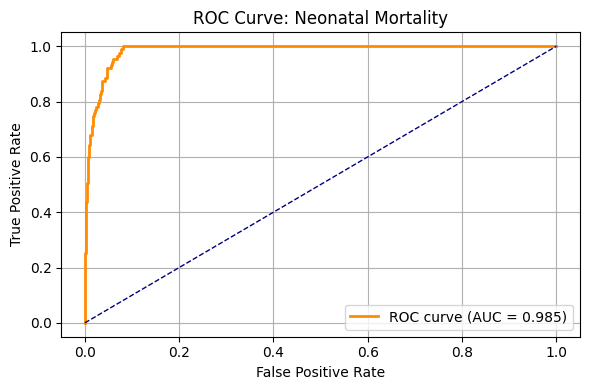

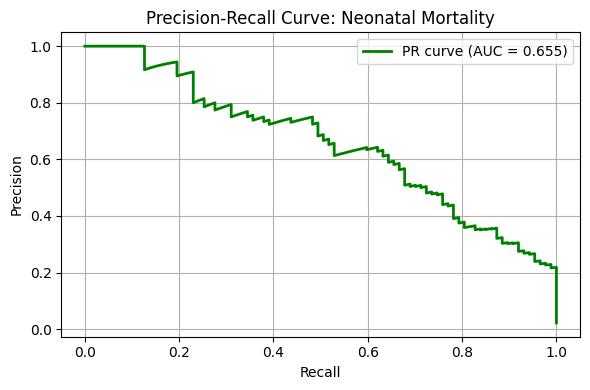

In [21]:
baseline_logistic(X, df['under5_mortality'], 'Under-5 Mortality')
baseline_logistic(X, df['infant_mortality'], 'Infant Mortality')
baseline_logistic(X, df['neonatal_mortality'], 'Neonatal Mortality')

## Logistic Regression with SMOTE

In [22]:
smote_pipe = Pipeline([
    ('preprocessor', preprocessor),      # <--- reuse the preprocessor you just built
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [23]:
from sklearn.metrics import average_precision_score
def logistic_with_smote(X, y, name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    smote_pipe.fit(X_train, y_train)
    y_pred = smote_pipe.predict(X_test)
    y_prob = smote_pipe.predict_proba(X_test)[:, 1]   # probabilities for ROC/PR

    print(f"\n--- Logistic Regression + SMOTE : {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("PR-AUC:", average_precision_score(y_test, y_prob))

In [24]:
# Run for each target
logistic_with_smote(X, df['under5_mortality'], 'Under-5 Mortality')
logistic_with_smote(X, df['infant_mortality'], 'Infant Mortality')
logistic_with_smote(X, df['neonatal_mortality'], 'Neonatal Mortality')


--- Logistic Regression + SMOTE : Under-5 Mortality ---
Accuracy: 0.9564772145417306
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3767
           1       0.45      0.96      0.61       139

    accuracy                           0.96      3906
   macro avg       0.72      0.96      0.79      3906
weighted avg       0.98      0.96      0.96      3906

F2 Score: 0.779601406799531
ROC-AUC: 0.9881572841010441
PR-AUC: 0.6998693377442627

--- Logistic Regression + SMOTE : Infant Mortality ---
Accuracy: 0.9541730670762929
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3870
           1       0.13      0.69      0.22        36

    accuracy                           0.95      3906
   macro avg       0.56      0.83      0.60      3906
weighted avg       0.99      0.95      0.97      3906

F2 Score: 0.37091988130563797
ROC-AUC: 0.965798162503589
PR-AUC: 0.16144678171847987

--- Lo

In [25]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import  make_scorer


## Neural network

In [26]:
#! pip install scikeras


In [27]:
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [28]:
## building the neural network
def build_nn(hidden_units=64, dropout=0.3, learning_rate=0.001, meta=None):
    """
    meta: scikeras passes a dict with data info
    meta['n_features_in_'] is the number of columns after preprocessing
    """
    n_features = meta["n_features_in_"]

    model = keras.Sequential([
        layers.Input(shape=(n_features,)),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(hidden_units//2, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model


In [29]:
nn_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, k_neighbors=1)),
    ('nn', KerasClassifier(
        model=build_nn,
        epochs=30,           # default values; will be overridden by grid search
        batch_size=32,
        verbose=0
    ))
])

In [30]:
param_grid = {
    'nn__hidden_units': [32, 64],
    'nn__dropout': [0.2, 0.3],
    'nn__learning_rate': [0.001, 0.0005],
    'nn__epochs': [20, 30],
    'nn__batch_size': [32, 64]
}


In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=nn_pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)

In [32]:
def train_eval_nn(X, y, target_name, pipeline=nn_pipe):
    """
    Train and evaluate the neural network pipeline on one target.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix.
    y : pd.Series or np.array
        Binary target column.
    target_name : str
        Name of the target for display in the report.
    pipeline : sklearn.pipeline.Pipeline
        The neural network pipeline (with preprocessing + SMOTE + KerasClassifier).
    """

    # Split data with stratification to keep class balance
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]   # probability for class 1

    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    f2  = fbeta_score(y_test, y_pred, beta=2)
    roc = roc_auc_score(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    # Report
    print(f"\n==== Neural Network Results: {target_name} ====")
    print(f"Accuracy:   {acc:.3f}")
    print(f"F2 Score:   {f2:.3f}")
    print(f"ROC-AUC:    {roc:.3f}")
    print(f"PR-AUC:     {pr_auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))
        # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f"Confusion Matrix: {target_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {target_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # --- Precision-Recall Curve ---
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {target_name}')
    plt.legend(loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.show()




==== Neural Network Results: Under-5 Mortality ====
Accuracy:   0.988
F2 Score:   0.803
ROC-AUC:    0.997
PR-AUC:     0.905

Classification Report:
              precision    recall  f1-score   support

           0      0.992     0.995     0.994      3767
           1      0.853     0.791     0.821       139

    accuracy                          0.988      3906
   macro avg      0.923     0.893     0.907      3906
weighted avg      0.987     0.988     0.987      3906



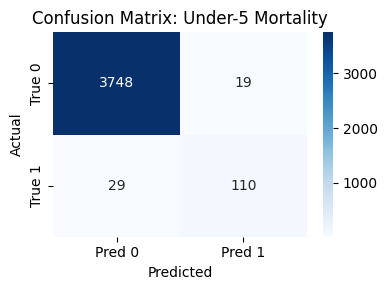

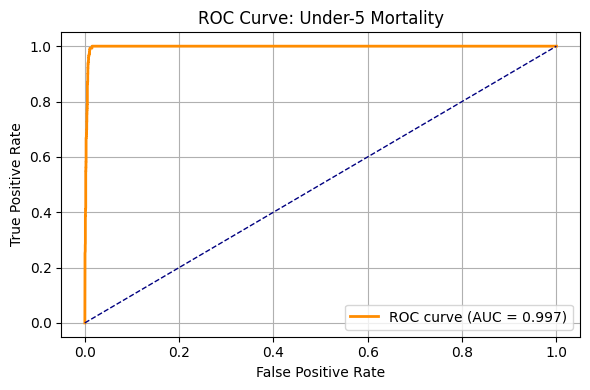

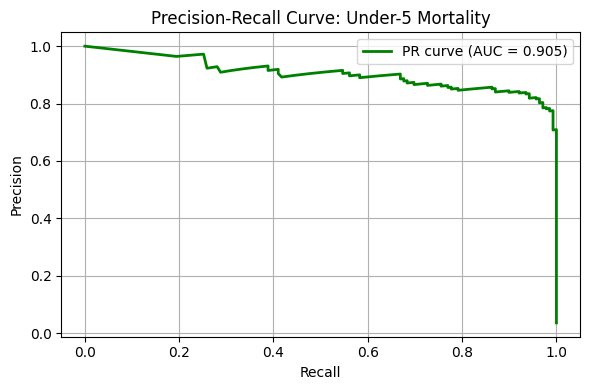


==== Neural Network Results: Infant Mortality ====
Accuracy:   0.991
F2 Score:   0.223
ROC-AUC:    0.974
PR-AUC:     0.300

Classification Report:
              precision    recall  f1-score   support

           0      0.993     0.998     0.995      3870
           1      0.538     0.194     0.286        36

    accuracy                          0.991      3906
   macro avg      0.766     0.596     0.641      3906
weighted avg      0.988     0.991     0.989      3906



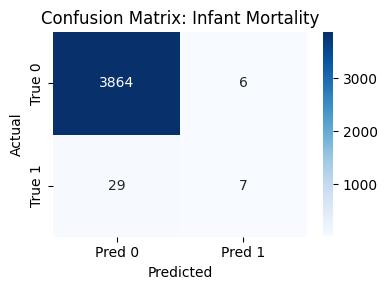

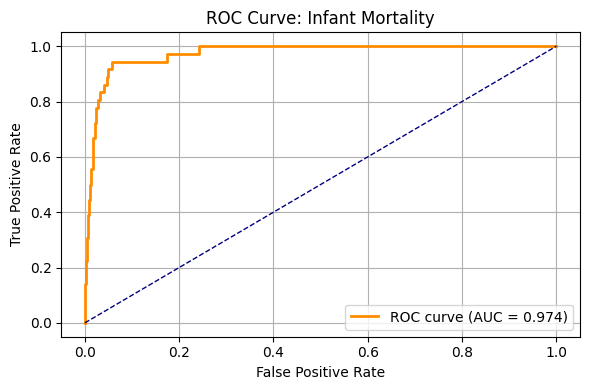

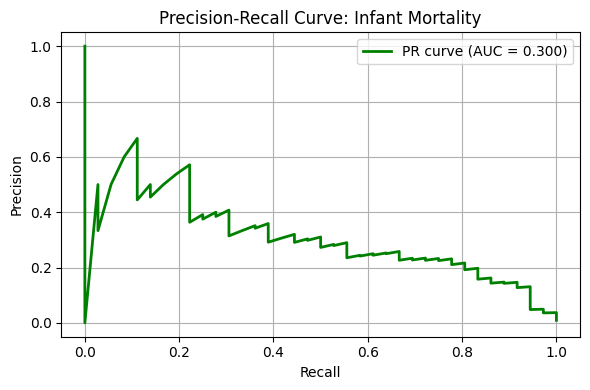


==== Neural Network Results: Neonatal Mortality ====
Accuracy:   0.986
F2 Score:   0.700
ROC-AUC:    0.994
PR-AUC:     0.760

Classification Report:
              precision    recall  f1-score   support

           0      0.993     0.993     0.993      3819
           1      0.693     0.701     0.697        87

    accuracy                          0.986      3906
   macro avg      0.843     0.847     0.845      3906
weighted avg      0.987     0.986     0.986      3906



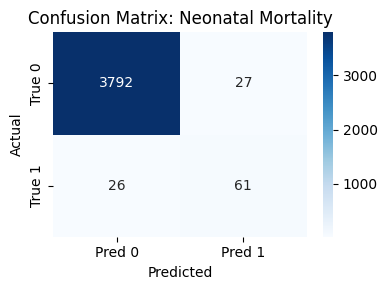

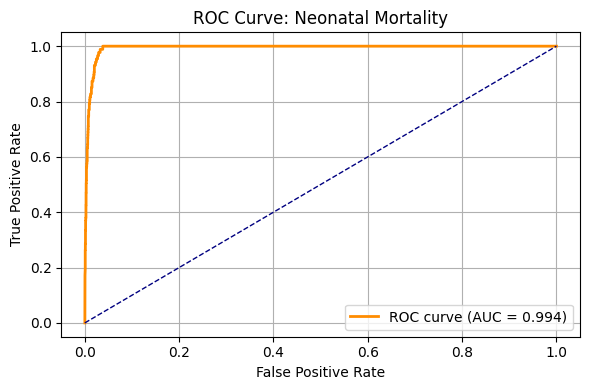

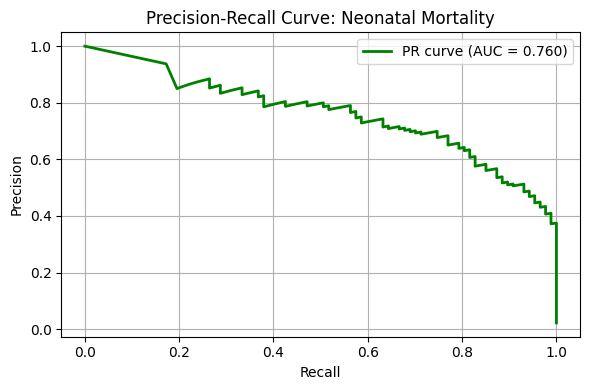

In [33]:
train_eval_nn(X, df['under5_mortality'], 'Under-5 Mortality')
train_eval_nn(X, df['infant_mortality'], 'Infant Mortality')
train_eval_nn(X, df['neonatal_mortality'], 'Neonatal Mortality')


### Neural Network + ensemble method


=== Under-5 results for === Stacking Ensemble
Accuracy: 0.9938556067588326
F2 Score: 0.9666203059805285
ROC-AUC: 0.9987509859380879
PR-AUC : 0.9480175927402353
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3767
           1       0.85      1.00      0.92       139

    accuracy                           0.99      3906
   macro avg       0.93      1.00      0.96      3906
weighted avg       0.99      0.99      0.99      3906



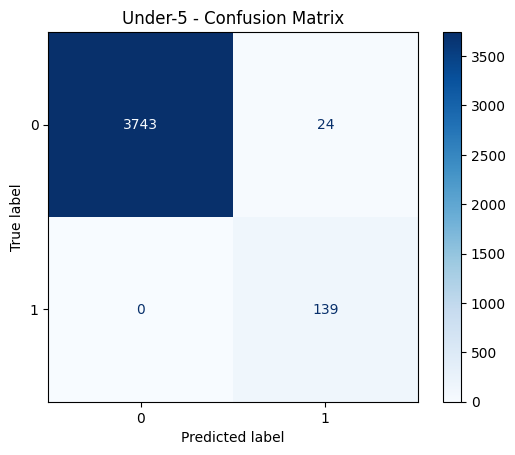

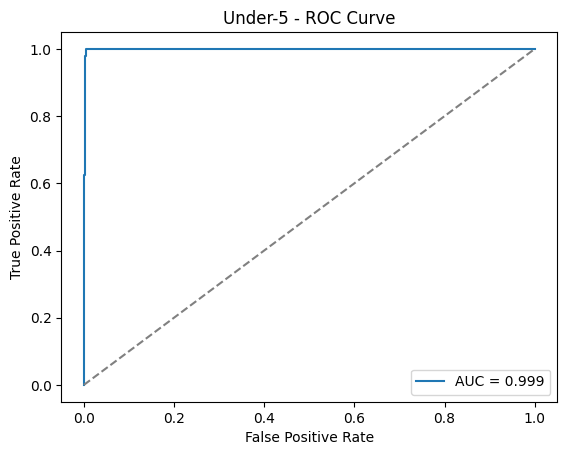

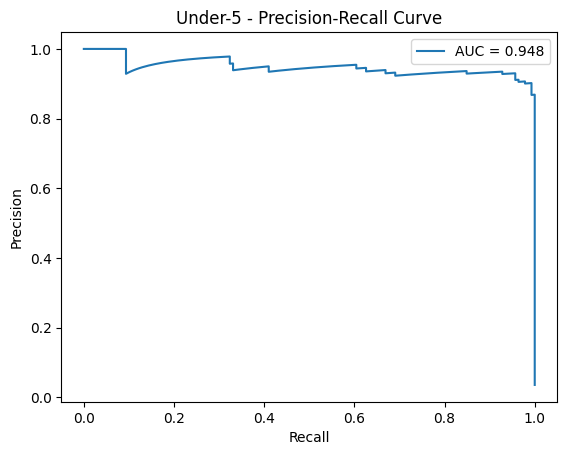


=== Infant results for === Stacking Ensemble
Accuracy: 0.9772145417306708
F2 Score: 0.6415094339622641
ROC-AUC: 0.9909776055124893
PR-AUC : 0.42009349463340284
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3870
           1       0.28      0.94      0.43        36

    accuracy                           0.98      3906
   macro avg       0.64      0.96      0.71      3906
weighted avg       0.99      0.98      0.98      3906



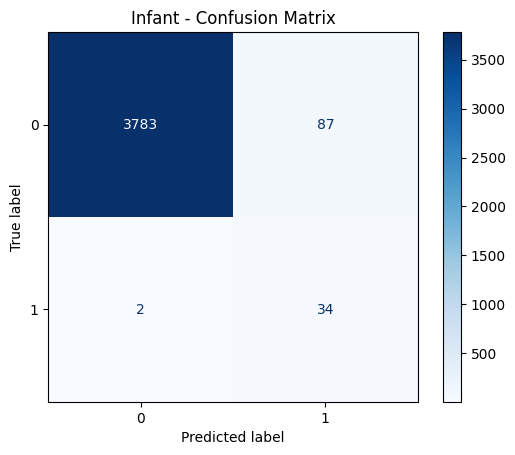

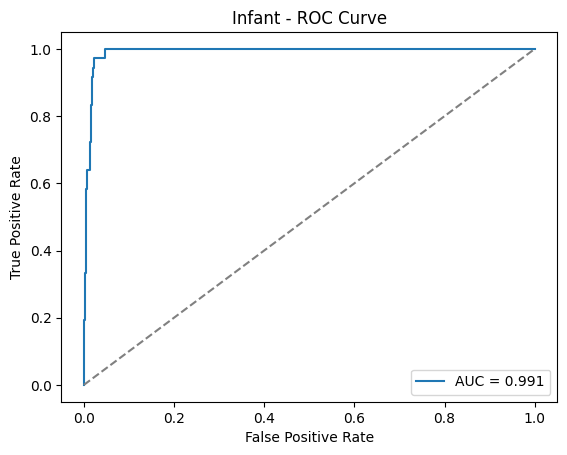

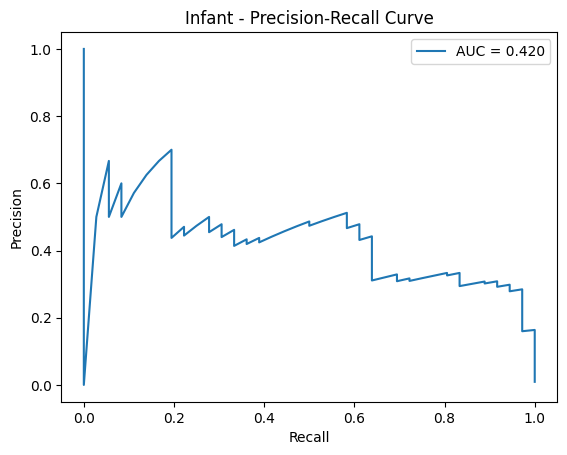


=== Neonatal results for === Stacking Ensemble
Accuracy: 0.9818228366615463
F2 Score: 0.8531746031746031
ROC-AUC: 0.9956689631094378
PR-AUC : 0.8412434883525642
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3819
           1       0.55      0.99      0.71        87

    accuracy                           0.98      3906
   macro avg       0.78      0.99      0.85      3906
weighted avg       0.99      0.98      0.98      3906



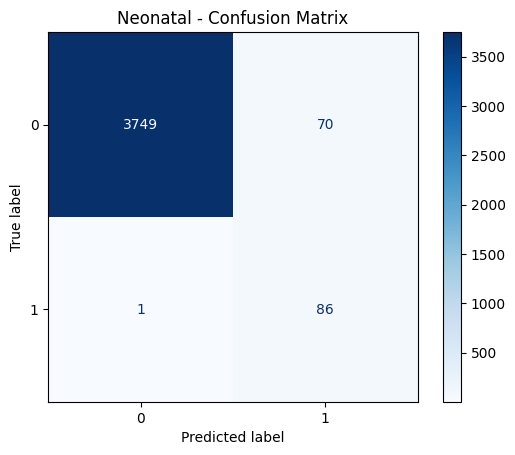

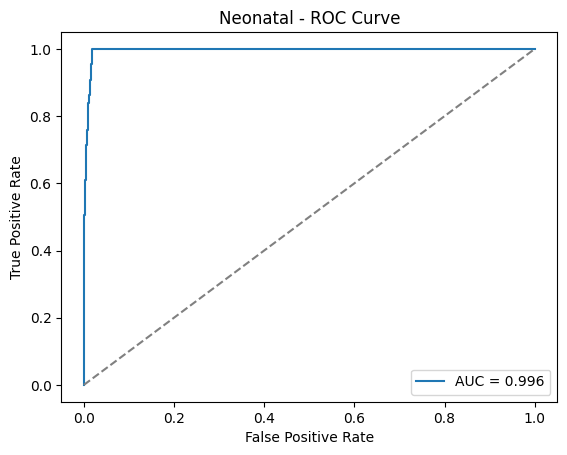

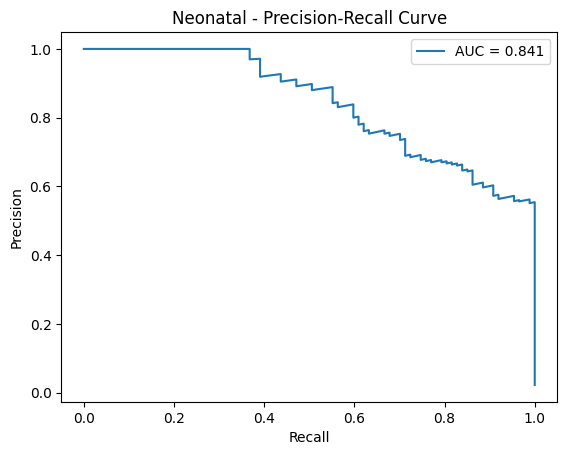

In [34]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, fbeta_score, roc_auc_score,
    precision_recall_curve, auc, classification_report,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
# OPTIONAL: uncomment if you want SMOTE
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImbPipeline

# ---------------------------------------------------------
# Function to build & fit the stacking ensemble
# (scale_pos_weight is computed per target inside loop)
# ---------------------------------------------------------
def stacking_ensemble(pos_weight):
    gb_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', GradientBoostingClassifier(random_state=42))
    ])

    rf_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(
            random_state=42,
            class_weight='balanced'   # <<< handles imbalance
        ))
    ])

    xgb_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(
            random_state=42,
            eval_metric='logloss',
            scale_pos_weight=pos_weight  # <<< imbalance handling
        ))
    ])

    # nn_pipe assumed defined with class_weight if supported
    estimators = [
        ('gb', gb_pipe),
        ('rf', rf_pipe),
        ('xgb', xgb_pipe),
        ('nn', nn_pipe)
    ]
    stack = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(
            max_iter=1000,
            class_weight='balanced'     # <<< helps meta-learner
        ),
        n_jobs=1
    )
    return stack

# ---------------------------------------------------------
# Evaluation helper
# ---------------------------------------------------------
def evaluate_model(model, X_test, y_test, label, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"\n=== {label} results for === {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("PR-AUC :", auc(*precision_recall_curve(y_test, y_prob)[1::-1]))
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(
        cmap="Blues", values_format="d")
    plt.title(f"{label} - Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{label} - ROC Curve")
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure()
    plt.plot(recall, precision,
             label=f"AUC = {auc(recall, precision):.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{label} - Precision-Recall Curve")
    plt.legend()
    plt.show()

# ---------------------------------------------------------
# Train + evaluate for each target
# ---------------------------------------------------------
targets = {
    'Under-5': df['under5_mortality'],
    'Infant':  df['infant_mortality'],
    'Neonatal': df['neonatal_mortality']
}

for name, y in targets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # --- compute ratio of negatives to positives for XGB ---
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    pos_weight = n_neg / n_pos if n_pos > 0 else 1.0

    stack = stacking_ensemble(pos_weight)
    stack.fit(X_train, y_train)
    evaluate_model(stack, X_test, y_test, label=name, model_name="Stacking Ensemble")


## Feature Importance